In [1]:
import controllers
import controlpy
import control_utils
import dynamics_models
import numpy as np
import matplotlib.pyplot as plt
import polytope
import tqdm
import uncertainty_utils

## Setup Drone Dynamics

In [2]:
# Dynamics Parameters
n_states = 6
n_inputs = 2
dt = 0.1
m = 0.5
l = 0.4
I = (1 / 3) * m * (l**2)
init_state = np.array([3,3,0,.3,.3,0])
state_limits = polytope.box2poly([[-2,4],[-2,4],[-np.pi/3, np.pi/3]])
u_min = 0
u_max = 5
input_limits = polytope.box2poly([[u_min,u_max], [u_min,u_max]])
input_bounds = [np.array([u_min, u_min]), np.array([u_max, u_max])]
offset = m * dynamics_models.GRAVITY / 2

# Control Task
Q = np.diag([10,10,1,1,1,1])
R = np.eye(n_inputs)

# Noise and Disturbances
process_noise_var = 1e-3
process_noise = process_noise_var * np.eye(n_states)
t = uncertainty_utils.calc_t(0.95, n_states)
# disturbance_set = uncertainty_utils.get_elipse(t, process_noise, np.zeros(n_states))
db = t * np.sqrt(process_noise_var)
disturbance_bound = polytope.box2poly([[-db, db]] * n_states)

# Experiment Details
episode_length = int(5 / dt)
controller_horizon = 10
state_reference = np.zeros(n_states)
A_state = np.hstack((state_limits.A, np.zeros((state_limits.A.shape[0],3))))
state_constraints = (A_state, state_limits.b)
input_constraints = (input_limits.A, input_limits.b)

# Vehicle
def get_vehicle():
    vehicle = dynamics_models.PlanarQuadrotor(init_state, m, l , I, dt, process_noise)
    return vehicle

def sim_traj(vehicle, controller, input_limits, episode_length=episode_length, linearize=False):
    x_traj = [vehicle.x]
    u_traj = []
    
    x_pred_trajs = []
    u_pred_trajs = []

    for _ in tqdm.tqdm(range(episode_length)):
        u_command = controller.solve(x_traj[-1])
        if u_command is None:
            print("controller error at iteration %d" %_)
            break
        if linearize:
            A, B, C = control_utils.linearize_around(vehicle, controller.x_traj.value, controller.u_traj.value, dt)
            controller.set_models(A,B,C)
        u = np.minimum(np.maximum(input_limits[0], u_command), input_limits[1])
        x_next = vehicle.f(u)

        x_traj.append(x_next)
        u_traj.append(u)
        
        x_pred_trajs.append(controller.x_traj.value.T)
        u_pred_trajs.append(controller.u_traj.value.T)
        
    return np.array(x_traj), np.array(u_traj), x_pred_trajs, u_pred_trajs

## Run initial Iteration

In [3]:
vehicle = get_vehicle()
A, B, C = vehicle.get_linearization(init_state, np.array([offset, offset]) / 2, dt)
controller = controllers.LTI_MPC_Tracker(A, B, C,
                                         controller_horizon, 
                                         Q, R, state_reference, 
                                         state_constraints, input_constraints)
controller.build()

In [4]:
x_init_traj, u_init_traj, x_init_preds, u_init_preds = sim_traj(vehicle, controller, input_bounds)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.30it/s]


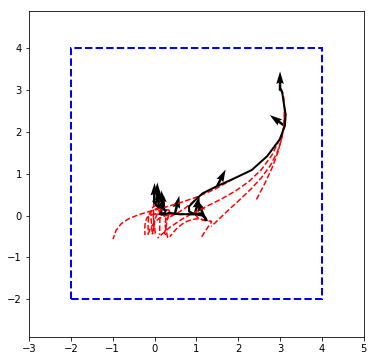

In [5]:
k = 5
lims = (-3,5)
lw = 2
state_proj = state_limits.project(np.arange(2) + 1)
plt.figure(figsize=(6,6))
plt.axis("equal")
plt.xlim(lims)
plt.ylim(lims)

ax = plt.gca()
state_proj.plot(ax=ax, alpha=1, color="w", edgecolor="b", linewidth=lw)
for x_pred in x_init_preds[::3]:
    plt.plot(x_pred[:,0], x_pred[:,1], "r--")
plt.plot(x_init_traj[:,0], x_init_traj[:,1], "k-", linewidth=lw)

plt.quiver(x_init_traj[::k,0], x_init_traj[::k,1], - np.sin(x_init_traj[::k,2]),   np.cos(x_init_traj[::k,2]))

## Setup LTI style LMPC

In [27]:
num_episodes = 10
controller = controllers.LTI_LMPC(A, B, C,
                                     controller_horizon, 
                                     Q, R, state_reference, 
                                     state_constraints, input_constraints)
h = lambda x, u: x.T @ Q @ x + u.T @ R @ u
value_function = control_utils.compute_traj_cost(x_init_traj[:-1,:].T, u_init_traj.T, h)
controller.add_trajectory(x_init_traj[:-1,:].T, u_init_traj.T, value_function)

In [28]:
for episode in range(num_episodes):
    vehicle = get_vehicle()
    x_traj, u_traj, x_preds, u_preds = sim_traj(vehicle, controller, input_bounds)
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, h)
    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)

  8%|██████▋                                                                            | 4/50 [00:00<00:07,  5.78it/s]

controller error at iteration 4



100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.25it/s]


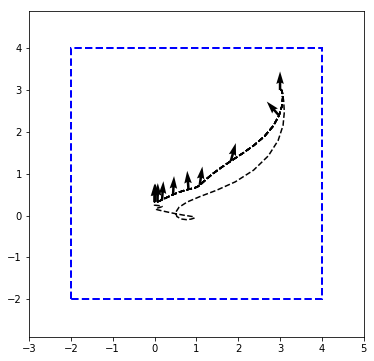

In [29]:
k = 5
lims = (-3,5)
lw = 2
state_proj = state_limits.project(np.arange(2) + 1)
plt.figure(figsize=(6,6))
plt.axis("equal")
plt.xlim(lims)
plt.ylim(lims)

ax = plt.gca()
state_proj.plot(ax=ax, alpha=1, color="w", edgecolor="b", linewidth=lw)

for x_traj in controller.traj_list:
    plt.plot(x_traj[0,:], x_traj[1,:], "k--")

x_traj = controller.traj_list[-1].T
plt.quiver(x_traj[::k,0], x_traj[::k,1], - np.sin(x_traj[::k,2]),   np.cos(x_traj[::k,2]))

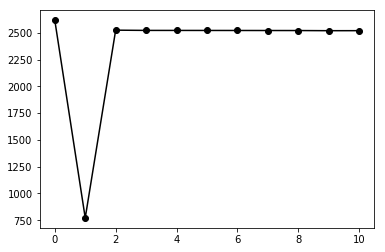

In [30]:
lti_costs = [q[0] for q in controller.value_func_list]
plt.plot(lti_costs, "k-o")

## LTV LMPC

In [6]:
num_episodes = 10
controller = controllers.LTV_LMPC(A, B, C,
                                     controller_horizon, 
                                     Q, R, state_reference, 
                                     state_constraints, input_constraints)
h = lambda x, u: x.T @ Q @ x + u.T @ R @ u
value_function = control_utils.compute_traj_cost(x_init_traj[:-1,:].T, u_init_traj.T, h)
controller.add_trajectory(x_init_traj[:-1,:].T, u_init_traj.T, value_function)

In [32]:
for episode in range(num_episodes):
    vehicle = get_vehicle()
    x_traj, u_traj, x_preds, u_preds = sim_traj(vehicle, controller, input_bounds, linearize=True)
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, h)
    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)

  8%|██████▋                                                                            | 4/50 [00:00<00:08,  5.40it/s]

controller error at iteration 4



 32%|██████████████████████████▏                                                       | 16/50 [00:03<00:06,  5.32it/s]

controller error at iteration 16



 16%|█████████████▎                                                                     | 8/50 [00:01<00:07,  5.51it/s]

controller error at iteration 8



100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.59it/s]


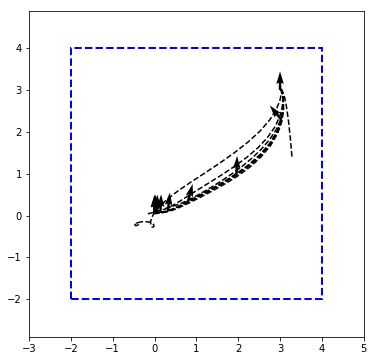

In [33]:
k = 5
lims = (-3,5)
lw = 2
state_proj = state_limits.project(np.arange(2) + 1)
plt.figure(figsize=(6,6))
plt.axis("equal")
plt.xlim(lims)
plt.ylim(lims)

ax = plt.gca()
state_proj.plot(ax=ax, alpha=1, color="w", edgecolor="b", linewidth=lw)

for x_traj in controller.traj_list[3:]:
    plt.plot(x_traj[0,:], x_traj[1,:], "k--")

x_traj = controller.traj_list[-1].T
plt.quiver(x_traj[::k,0], x_traj[::k,1], - np.sin(x_traj[::k,2]),   np.cos(x_traj[::k,2]))

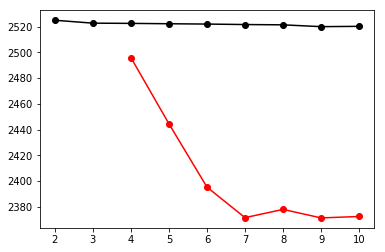

In [40]:
ltv_costs = [q[0] for q in controller.value_func_list]
lti_costs_inf = np.hstack(([np.NaN] * 2,lti_costs[2:]))
ltv_costs_inf = np.hstack(([np.NaN] * 4,ltv_costs[4:]))
plt.plot(lti_costs_inf, "k-o")
plt.plot(ltv_costs_inf, "r-o")

## LTI Tube LMPC

In [6]:
num_episodes = 10

controller = controllers.LTI_Tube_LMPC(A, B, C,
                                     controller_horizon, 
                                     Q, R, state_reference, 
                                     state_constraints, input_constraints, 
                                    (disturbance_bound.A, disturbance_bound.b))
h = lambda x, u: x.T @ Q @ x + u.T @ R @ u
value_function = control_utils.compute_traj_cost(x_init_traj[:-1,:].T, u_init_traj.T, h)
controller.add_trajectory(x_init_traj[:-1,:].T, u_init_traj.T, value_function)

> c:\users\rohan\documents\modestyachts2019\prediction uncertainty\control_utils.py(156)minimal_invariant()
-> M_hat = W
(Pdb) n
> c:\users\rohan\documents\modestyachts2019\prediction uncertainty\control_utils.py(157)minimal_invariant()
-> for i in range(1, n + 1):
(Pdb) n
> c:\users\rohan\documents\modestyachts2019\prediction uncertainty\control_utils.py(158)minimal_invariant()
-> AW = poly_transform(W, np.linalg.matrix_power(A, i))
(Pdb) n
> c:\users\rohan\documents\modestyachts2019\prediction uncertainty\control_utils.py(159)minimal_invariant()
-> if AW.volume != 0:
(Pdb) AW.vertices.shape
*** AttributeError: 'NoneType' object has no attribute 'shape'
(Pdb) polytope.extreme(AW).shape
(64, 6)
(Pdb) n
> c:\users\rohan\documents\modestyachts2019\prediction uncertainty\control_utils.py(160)minimal_invariant()
-> M_hat = minkowski_sum(M_hat, AW)
(Pdb) s
--Call--
> c:\users\rohan\documents\modestyachts2019\prediction uncertainty\control_utils.py(57)minkowski_sum()
-> def minkowski_sum(A, 

BdbQuit: 

In [ ]:
for episode in range(num_episodes):
    vehicle = get_vehicle()
    x_traj, u_traj, x_preds, u_preds = sim_traj(vehicle, controller, input_bounds)
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, h)
    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

In [15]:
data = np.random.rand(50,6)
p = polytope.qhull(data)

KeyboardInterrupt: 

In [16]:
import scipy.spatial

In [17]:
chull = scipy.spatial.ConvexHull(data)

In [18]:
chull.equations

array([[ 0.23657,  0.54411, -0.33845, ..., -0.51395, -0.49371, -0.04236],
       [ 0.06044,  0.25817, -0.48479, ..., -0.33573, -0.7624 ,  0.24113],
       [ 0.21615,  0.23087,  0.27075, ...,  0.07872, -0.89737, -0.1478 ],
       ...,
       [-0.07657, -0.53645,  0.60001, ..., -0.56433,  0.11135, -0.23146],
       [-0.08006, -0.53775,  0.59428, ..., -0.56749,  0.11622, -0.228  ],
       [-0.08223, -0.5337 ,  0.59583, ..., -0.56903,  0.11667, -0.22938]])

In [61]:
import cvxpy as cp
import scipy

In [62]:
n = 10
a = np.random.rand(n)
b = np.random.rand(n)
A = np.random.rand(n,n)
B = np.random.rand(n,n)
A = A.T @ A
B = B.T @ B

In [63]:
x = cp.Variable(n)
y = cp.Variable(n)
t = cp.Variable()
constraint = [cp.quad_form(x, A) <= t, t >= cp.quad_form(y, B)]
cost = cp.Minimize(a.T @ (x + y) + 100*t)
prob = cp.Problem(cost, constraint)
prob.solve(solver=cp.ECOS)
print(x.value, y.value)

[ 0.25421 -0.10258 -0.0175  -0.26007  0.13918  0.13013  0.12698 -0.0281
 -0.08876 -0.15037] [ 0.19985  0.0949   0.06218 -0.116    0.0329  -0.00077  0.11791 -0.17382
  0.08422 -0.33486]


In [64]:
x = cp.Variable(n)
y = cp.Variable(n)
constraint = [cp.norm(scipy.linalg.sqrtm(A)@ x) <= b.T @ y]
cost = cp.Minimize(a.T @ (x + y))
prob = cp.Problem(cost, constraint)
prob.solve(solver=cp.ECOS)
print(x.value, y.value)

None None


In [65]:
np.sqrt(8)

2.8284271247461903

In [7]:
controller.init_constraint[0].shape

(570453, 6)

In [31]:
P = polytope.Polytope(*controller.init_constraint)
P.A.shape
polytope.reduce(P)

MemoryError: Unable to allocate array with shape (570453, 570453) and data type float64

In [28]:
p = P.project([1,2])

(-0.025712868075057155,
 0.025712868075057165,
 -0.024444365674515082,
 0.024444365674515082)

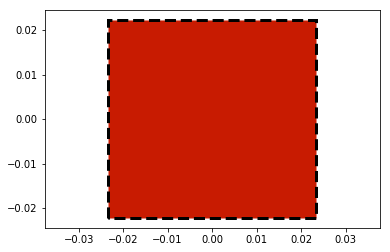

In [29]:
plt.figure()
ax = plt.gca()
# state_proj.plot(ax=ax, alpha=0.1)
p.plot(ax=ax)

plt.xlim(-0.1,0.1)
plt.axis("equal")

In [8]:
disturbance_bound.A.shape

(12, 6)

In [14]:
K, _, _= controlpy.synthesis.controller_lqr_discrete_time(A, B, Q, R)
X = polytope.Polytope(*state_constraints)
O =control_utils.maximal_invariant(X, A=A, B=B, K=K, U=input_limits)

(-2.3, 4.3, -2.3000000000000007, 4.3)

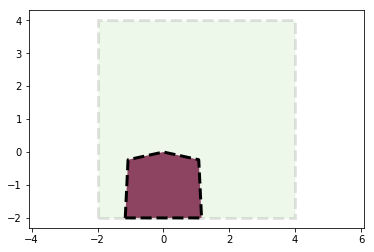

In [20]:
plt.figure()
ax = plt.gca()
state_proj.plot(ax=ax, alpha=0.1)
Op = O.project([1,2])
Op.plot(ax=ax)
plt.xlim(3,6)
plt.axis("equal")

In [9]:
B.shape

(6, 2)

In [10]:
K.shape

(2, 6)

In [12]:
input_limits.A.shape

(4, 2)

In [13]:
state_limits.A.shape

(6, 3)